In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if IS_COLAB:
    !git clone https://github.com/wpan03/quick_ds_python.git
    %cd quick_ds_python
    !pip install treeinterpreter==0.2.3
    !pip install scikit-learn==0.24.1
    !pip install tune-sklearn ray[tune]
else:
    %load_ext autoreload
    %autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from ray.tune.sklearn import TuneSearchCV


from src.eda import see_missing, plot_corr_heatmap, get_freq_table
from src.preprocess import get_x_y, get_preprocessor, do_transform
from src.evaluate import binary_evaluation, binary_cross_evaluate
from src.explain import (get_feature_imp, get_permute_imp_df, plot_permute_imp,
                         get_binary_error_analysis, plot_single_instance_explaination)
from src.model_supervised import find_dt_clf_max_depth


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/wpan03/quick_ds_python/master/data/titanic_train.csv')

## EDA

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.shape

(891, 12)

In [6]:
see_missing(df, only_missing=True)

,columns,total_missing,percent_missing
0,Cabin,687,77.104377
1,Age,177,19.865320
2,Embarked,2,0.224467


In [7]:
plot_corr_heatmap(df)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.00,-0.01,-0.04,0.04,-0.06,-0.00,0.01
Survived,-0.01,1.00,-0.34,-0.08,-0.04,0.08,0.26
Pclass,-0.04,-0.34,1.00,-0.37,0.08,0.02,-0.55
Age,0.04,-0.08,-0.37,1.00,-0.31,-0.19,0.10
SibSp,-0.06,-0.04,0.08,-0.31,1.00,0.41,0.16
Parch,-0.00,0.08,0.02,-0.19,0.41,1.00,0.22
Fare,0.01,0.26,-0.55,0.10,0.16,0.22,1.00


In [8]:
get_freq_table(df, 'Survived')

,count,percentage
0,549,0.616162
1,342,0.383838


In [9]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [10]:
model_vars = ['Pclass', 'Sex', 'Age', 'Fare', 'Survived']

## Preprocess

### Train and Test Split

In [11]:
df_mod = df[model_vars]

In [12]:
X, y = get_x_y(df_mod, label_col='Survived')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=36)

### Encode and Impute

In [14]:
oh_enc = preprocessing.OneHotEncoder(drop='if_binary')
med_imp = SimpleImputer(strategy='median')

In [15]:
preprocessor = get_preprocessor(oh_enc, med_imp)
preprocessor

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa0478f9d90>),
                                ('simpleimputer',
                                 SimpleImputer(strategy='median'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa04117d280>)])

In [16]:
_ = preprocessor.fit(X)

In [17]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names()) + preprocessor.transformers_[1][2]
col_names

['x0_male', 'Pclass', 'Age', 'Fare']

In [18]:
X_train_prepared = do_transform(X_train, preprocessor, col_names)
X_test_prepared = do_transform(X_test, preprocessor, col_names)

## Fit Model

In [19]:
mod_rf = RandomForestClassifier(random_state=36)

In [20]:
_ = mod_rf.fit(X_train_prepared, y_train)

In [21]:
binary_evaluation(X_train_prepared, y_train, mod_rf)

,metrics,value
0,accuracy,0.979042
1,balanced acc,0.975351
2,precision,0.983740
3,recall,0.960317
4,f1,0.971888


In [22]:
binary_cross_evaluate(X_train_prepared, y_train, mod_rf)

,fit_time,score_time,test_accuracy,test_f1
0,0.117255,0.010585,0.820628,0.759036
1,0.103371,0.010426,0.807175,0.732919
2,0.102895,0.010214,0.756757,0.662500


## Hyperparameter Tuning

In [23]:
rf_grids = {'max_features': ['auto', 'sqrt', 0.5],
            'min_samples_leaf': [1, 3, 5, 7, 9],
            'n_estimators': [50, 100, 200, 400]}

In [24]:
%%time
tune_search = TuneSearchCV(RandomForestClassifier(), rf_grids, cv=3,
                           n_trials=20, n_jobs=-1,
                           random_state=36, search_optimization='hyperopt')
_ = tune_search.fit(X_train_prepared, y_train)


CPU times: user 906 ms, sys: 274 ms, total: 1.18 s
Wall time: 8.93 s


In [25]:
df_cv_result= pd.DataFrame(tune_search.cv_results_)
df_cv_result.loc[:, ~df_cv_result.columns.str.startswith('split')]\
            .drop(['params'], axis=1)\
            .sort_values('rank_test_score', ignore_index=True)\
            .head()

,mean_test_score,std_test_score,rank_test_score,time_total_s,training_iteration,param_max_features,param_min_samples_leaf,param_n_estimators
0,0.811296,0.048428,1,0.454317,1,0.5,5,50
1,0.809808,0.040755,2,1.609898,1,sqrt,5,200
2,0.806811,0.040722,3,0.381039,1,sqrt,5,50
3,0.806805,0.044391,4,0.874915,1,0.5,5,100
4,0.805323,0.035245,5,0.352804,1,0.5,7,50


In [26]:
tune_search.best_params_

{'max_features': 0.5, 'min_samples_leaf': 5, 'n_estimators': 50}

In [27]:
tune_search.best_score_

0.8112956005332688

In [28]:
mod_rf_final = tune_search.best_estimator_

In [29]:
binary_cross_evaluate(X_train_prepared, y_train, mod_rf_final)

,fit_time,score_time,test_accuracy,test_f1
0,0.064208,0.008385,0.856502,0.786667
1,0.072912,0.009369,0.807175,0.726115
2,0.068260,0.007548,0.756757,0.662500


## Error Analysis

In [30]:
get_binary_error_analysis(X_test_prepared, y_test, mod_rf_final, only_show_error=True).head(5)

,x0_male,Pclass,Age,Fare,class1_prob,pred_class,actual_class,loss
0,0.0,1.0,2.0,151.55,0.999615,1,0,7.863267
1,0.0,1.0,25.0,151.55,0.997393,1,0,5.949617
2,0.0,2.0,26.0,26.00,0.981955,1,0,4.014911
3,1.0,2.0,62.0,10.50,0.022180,0,1,3.808582
4,0.0,2.0,44.0,26.00,0.945116,1,0,2.902526


## Explain the Model

### Random Forest Feature Importance

In [31]:
get_feature_imp(X_train_prepared, mod_rf_final)

,name,score
0,x0_male,0.395428
1,Fare,0.266290
2,Age,0.195266
3,Pclass,0.143016


### Permutation Feature Importance

Learn more about it [here](https://scikit-learn.org/stable/modules/permutation_importance.html).

In [32]:
df_permute, permute_result = get_permute_imp_df(mod_rf_final, X_test_prepared, y_test, return_full_result=True)

In [33]:
df_permute

,name,importance_mean,importance_std
0,x0_male,0.221525,0.012232
1,Pclass,0.102242,0.016391
2,Age,0.032287,0.014294
3,Fare,0.025112,0.009234


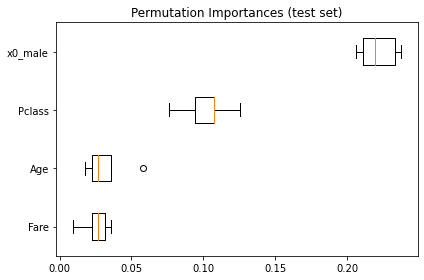

In [34]:
plot_permute_imp(X_test_prepared, permute_result)

### Surrogate Tree

See [here](https://christophm.github.io/interpretable-ml-book/global.html) for the idea behind surrogate tree.

In [35]:
y_train_surr = mod_rf_final.predict(X_train_prepared)

In [36]:
cv_dt_acc = find_dt_clf_max_depth(X_train_prepared, y_train, max_depth_range=range(1, 20))
cv_dt_acc

array([0.77688226, 0.77538076, 0.80083896, 0.8127971 , 0.78734564,
       0.79482622, 0.78589801, 0.77388599, 0.78136657, 0.78138677,
       0.77390619, 0.76938822, 0.75743681, 0.76193458, 0.75893158,
       0.75594204, 0.75294577, 0.75294577, 0.75294577])

In [37]:
mod_dt_surr = DecisionTreeClassifier(max_depth=3).fit(X_train_prepared, y_train_surr)

In [38]:
mod_dt_surr

DecisionTreeClassifier(max_depth=3)

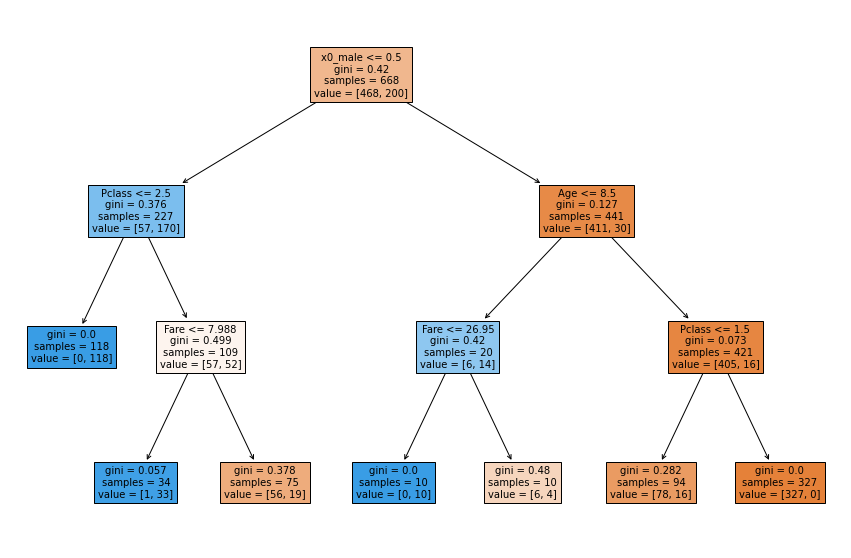

In [39]:
fig = plt.figure(figsize=(15, 10))
_ = plot_tree(mod_dt_surr, feature_names=X_test_prepared.columns, filled=True, fontsize=10)

### Tree Interpreter

See the [package repo](https://github.com/andosa/treeinterpreter).

In [40]:
instance = X_test_prepared.iloc[[18], :]
instance

,x0_male,Pclass,Age,Fare
18,1.0,1.0,61.0,33.5


In [41]:
plot_single_instance_explaination(mod_rf_final, instance)